## Bergfex Webscraping
<b> Milestone 3</b> 

In this part of our project, our aim is to find the nearest known snow level for the activities and to create a "snow alert" if necessary. Therefore, we use the files from Milestones 1 & 2 and compare the GPS coordinates. 
We then classify based on two conditions if a snow alert exists and add the 'snow status' to each activity.

### Installations

In [1]:
# unhash and run the below line once
#conda install -c conda-forge shapely
#conda install -c conda-forge geopy
# or 
#!pip install geopy

### Imports

In [2]:
import pandas as pd
import numpy as np

import shapely
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geopy.distance

import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt

# To Do

- MSJ: check the creation of snow_coordinates in notebook 2
- ????check if better data resolution for swiss_cities, if not add city_coordinates to data: makes the "check for yourself" useful
- Malwina - potentially at the end: add testing notebook for NB III to github? or add section to 'proof' it's working in final NB III

# 1 Importing existing files
First of all, we import the previously created files that contain all the scraped activities and the scraped snow level information.

In [3]:
# change the file_path to your path if necessary
filepath = '../data/'

# importing activity data
activities = pd.read_csv(filepath + 'activities_all_gpx.csv')

# importing snow level data merged with cities coordinates
snow = pd.read_csv(filepath + 'snow_coordinates.csv', sep=';', decimal=',')
snow = snow.dropna() 
# EPSG:4326/WGS84 ############ check?

# renaming the snow columns for later merging with the coordinates of the activity_df
snow = snow.rename(columns = {'lat':'snow_obs_lat', 'lng':'snow_obs_lng'})
snow = snow.rename(columns = {'location':'snow_obs_location', 'height_in_m':'snow_obs_alt'})
snow.head()

,snow_obs_location,snow_obs_alt,snowlevel_in_cm,snow_obs_lat,snow_obs_lng
2,Aigle,381,0,46.319025,6.970566
3,Altdorf,449,0,46.880600,8.639400
4,Andermatt,2282,0,46.602389,8.611800
5,Appenzell,780,0,47.333300,9.416700
6,Beatenberg,1182,0,46.703541,7.809551


In [4]:
snow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 2 to 76
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   snow_obs_location  48 non-null     object 
 1   snow_obs_alt       48 non-null     int64  
 2   snowlevel_in_cm    48 non-null     int64  
 3   snow_obs_lat       48 non-null     float64
 4   snow_obs_lng       48 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.2+ KB


# 2 Compare hike location and snow level location
Now, we want to calculate the closest point in that df to another gps point

- <b>1st step</b>: making Points out of the snow location #### correct?
- <b>2nd step</b>: making a single Multipoint object (grid) out of all the snow_points 

In [5]:
snow_point_list= [] # list that contains all the snow points in Point object format

# Iterating through all snow locations and creating a point made of lat & lon
for index, row in snow.iterrows():
    point = Point(row['snow_obs_lat'], row['snow_obs_lng'])
    snow_point_list.append(point)
    
len(snow_point_list) # 48 locations #### update # of loc?

# Creating a MultiPoint / Grid
snow_grid = MultiPoint(snow_point_list)

In [6]:
len(snow_point_list), snow_point_list[:5]

(48,
  <shapely.geometry.point.Point at 0x7f8f3654ee20>])

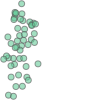

In [7]:
snow_grid

In [8]:
nearest_list = [] # list that contains tuples of nearest snow points in Point object format
near_lng = []  # contains the longitudes of the nearest snow point extracted from nearest shapely calculation
near_lat = []  # contains the latitudes of nearest snow point

# Finding which snow point is nearest to the test point 
for index, row in activities.iterrows():
    tested_point = Point(row['lat'], row['lon']) # iterates through each row of 'activities'####????
    nearest = nearest_points(tested_point, snow_grid) # records the nearest match
    nearest_list.append(nearest[1]) # the second item in the tuple is the nearest point

# Saving longitude & latitude of the nearest snow point in lists 
for i in range(len(nearest_list)):
    near_lng.append(nearest_list[i].y) 
    near_lat.append(nearest_list[i].x)

In [9]:
len(nearest_list), nearest_list[:5]

(3796,
  <shapely.geometry.point.Point at 0x7f8f36556ca0>])

In [10]:
nearest_list[0].y, nearest_list[0].x

(7.570987799999999, 47.5378697)

In [11]:
# Test: dataframe output works for each row of trails
# should not return an error
assert len(near_lng) == len(activities)

Now we need to match those calculated nearest coordinates
with the name of the snow_point with same coordinate. 
We merge the two dataframes on coordinates, with replicating 
the rows of snow points if necessary.

In [12]:
# Adding the coordinates of the nearest snow point to each 'activity'
activities['snow_obs_lat'] = near_lat
activities['snow_obs_lng'] = near_lng

# Merged 'snow' with 'activity' (expected len is length of 'activity')
merged = pd.merge(activities, snow, on=['snow_obs_lat','snow_obs_lng'])
merged.head()

,Unnamed: 0,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness,region,lat,lon,snow_obs_lat,snow_obs_lng,snow_obs_location,snow_obs_alt,snowlevel_in_cm
0,0,129549,Bornkänzeli,2 - medium,Hiking,10.30,03:00,318,392,665.0,2,3,aargau,47.320610,7.907470,47.53787,7.570988,Binningen,316,0
1,2,129607,Aarelauf,2 - medium,Hiking,11.34,02:30,75,391,428.0,2,3,aargau,47.320610,7.907470,47.53787,7.570988,Binningen,316,0
2,5,961881,Hüslischnegg am Asperstrihen,2 - medium,Hiking,5.00,01:23,173,670,804.0,3,3,aargau,47.436832,8.029861,47.53787,7.570988,Binningen,316,0
3,47,129624,Rundwanderung Engelberg,2 - medium,Hiking,11.17,03:30,283,395,702.0,1,3,aargau,47.320080,7.899660,47.53787,7.570988,Binningen,316,0
4,48,897134,PanoramatourAG-Strihen-ZeiherHomberg,1 - easy,Mountainbike,25.29,01:31,756,438,740.0,1,1,aargau,47.462158,7.996060,47.53787,7.570988,Binningen,316,0


# 3 Calculate the snow alert

## Condition 1: Relevance of snow level
We want to make sure our snow level is actually relevant: 
The snow point has to be less than 30 km away from the hike (30 km is in between the average resolution of the snow thickness maps of SLF ('Schnee- und Lawinenforschung'), the hi-res being 2-5 km, the larger one around 50).

In [13]:
# Calculating the distance between gps point and nearest point
distance = []  # contains the distances in km from snow measurement to hike start
for index, row in merged.iterrows(): # iterating through merged df
    gps_coords = (row['lat'], row['lon'])
    snow_coords = (row['snow_obs_lat'], row['snow_obs_lng'])
    d = round(geopy.distance.geodesic(gps_coords, snow_coords).km, 1)
    distance.append(d)

# Append distance to df and assign status
merged['distance'] = distance
merged['snow_status'] = 'check for yourself' # starting with a default status
merged.loc[merged['distance'] > 30, 'snow_status'] = 'No local data'
merged['snow_status'].unique() #for now only 'No local data', 'check for yourself'

array(['No local data', 'check for yourself'], dtype=object)

## Condition 2: Difference in Altitude
 i.e. altitude difference should be <1000m. 
- we chose 1000 m because it's the resolution of SLF data
- #1: if the snow measurement was done more than 1000 m lower than the max alt of the hike, we want a warning saying potential snow
- #2: if the measurement is more than 1000 m higher than the max alt, we want a message saying the hike is low altitude
- #3: if any snow point in a radius of 30 km of a lower altitude has snow, we want a snow warning
- #4: if the measurement is within 1000 m up and down of the highest point, we consider it accurate

In [1]:
# 'Snow' if max alt of the hike within 1000m vertical radius of snow point, otherwise 'check for yourself'
merged.loc[(merged['snowlevel_in_cm'] > 0) & (
    merged['max'] + 1000 > merged['snow_obs_alt']), 'snow_status'] = 'Snow'

# 'No snow' if there is no snow and the max alt is <1000m over the snow point, otherwise 'check for yourself'
merged.loc[(merged['snowlevel_in_cm'] == 0) & (
    merged['max'] <= merged['snow_obs_alt'] + 1000), 'snow_status'] = 'No Snow'

# 'No local data' if there is no snow and the max hike alt is >1000m over the snow point
merged.loc[(merged['snowlevel_in_cm'] == 0) & (
    merged['max'] > merged['snow_obs_alt'] + 1000), 'snow_status'] = 'No local data'

# if any snow point in a radius of 30 km of a lower altitude has snow, we want a snow warning
# if the measurement is within 1000 m up and down of the highest point, we consider it accurate

# drop Unnamed column
merged = merged.drop(columns = ['Unnamed: 0']) 
merged['snow_status'].unique(), merged

NameError: name 'merged' is not defined

Let's check how many activities are under snow alert!

In [19]:
snow_alert_act = merged[merged['snow_status'] == 'Snow']
snow_alert_act

,ID,title,difficulty,sport,length,time,climb,min,max,technique,...,region,lat,lon,snow_obs_lat,snow_obs_lng,snow_obs_location,snow_obs_alt,snowlevel_in_cm,distance,snow_status
943,870922,Gehrihorn,1 - easy,Hiking,6.65,03:20,1357,771,2129.0,1,...,bern-region,46.588749,7.651042,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,15.2,Snow
944,99640,Rund ums Wiriehore,2 - medium,Hiking,9.20,03:30,622,1410,2032.0,4,...,bern-region,46.599850,7.535519,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,14.2,Snow
945,744919,Kanderfälle,2 - medium,Hiking,2.32,01:00,165,1195,1328.0,3,...,bern-region,46.476624,7.663647,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,9.0,Snow
946,316229,Gipfelwanderung zum Rauflihorn,2 - medium,Hiking,15.33,06:00,1101,1222,2323.0,3,...,bern-region,46.565910,7.479245,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,11.6,Snow
947,700232,Rundtour über den Rüwlispass - Hornberg ins Sa...,2 - medium,Cycling,31.82,03:25,950,934,1836.0,2,...,bern-region,46.505466,7.400690,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,11.8,Snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,242439,Panoramarundweg Rosenboden,1 - easy,Hiking,2.91,00:55,128,2168,2260.0,1,...,ostschweiz,47.154945,9.312843,47.249385,9.343234,Santis,2490,20,10.7,Snow
3350,274524,Flugzeugfeeling auf dem Gulme,2 - medium,Hiking,11.36,03:30,1030,1085,1999.0,1,...,ostschweiz,47.207386,9.357194,47.249385,9.343234,Santis,2490,20,4.8,Snow
3353,713162,Säntis - Rotsteinpass – Altmannsattel – Zwing...,3 - difficult,Hiking,17.44,06:05,478,923,2460.0,0,...,ostschweiz,47.248711,9.342971,47.249385,9.343234,Santis,2490,20,0.1,Snow
3358,130793,Wildhaus - Gamserrugg - Voralp,3 - difficult,Hiking,13.78,06:00,1071,1016,1946.0,3,...,ostschweiz,47.203442,9.350650,47.249385,9.343234,Santis,2490,20,5.1,Snow


## Write CSV

In [21]:
merged.to_csv(filepath + 'activities_snow_alert.csv', index = False)

This is the end of this project.
Please do check out our next project where we create a dashboard in Tableau to visualize and select the activities. You will also learn how to create plots and dashboards in Tableau.
https://github.com/SarahDutschke/bergfex_snowalert_part_II